<a href="https://colab.research.google.com/github/musicjae/intro_to_python/blob/master/Pytorch/NLP/1%20BOW_logistic_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd

# Basic

In [5]:
# By default, it concatenates along the first axis (concatenates rows)
x_1 = torch.randn(2, 5)
y_1 = torch.randn(3, 5)
z_1 =torch.cat([x_1, y_1])
print(z_1.shape)

# Concatenate columns:
x_2 = torch.randn(2, 3)
y_2 = torch.randn(2, 5)
z_2 = torch.cat([x_2, y_2], 1) # second arg specifies which axis to concat along
print(z_2.shape)


torch.Size([5, 5])
torch.Size([2, 8])


In [19]:
data = autograd.Variable(torch.randn(2,5))
print(data)

tensor([[ 0.7870, -0.7939, -1.5257,  1.0286, -0.5081],
        [ 0.4564, -1.0762,  0.4435, -0.7559, -0.4279]])


In [20]:
lin = nn.Linear(5,3)
print(lin(data))

tensor([[ 0.4148,  0.9644,  0.1419],
        [-0.0628,  0.2385,  0.5309]], grad_fn=<AddmmBackward>)


In [21]:
relu = F.relu
print(relu(lin(data)))

tensor([[0.4148, 0.9644, 0.1419],
        [0.0000, 0.2385, 0.5309]], grad_fn=<ReluBackward0>)


In [22]:
softmax = F.softmax
print(softmax(relu(lin(data))))

tensor([[0.2862, 0.4959, 0.2179],
        [0.2519, 0.3197, 0.4284]], grad_fn=<SoftmaxBackward>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [23]:
print(softmax(relu(lin(data))).sum())

tensor(2., grad_fn=<SumBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


# BOW 분류기 로지스틱 회귀

## data load

In [74]:
data = [ ("이것 좀 주세요".split(), "KOREAN"),
         ("Give it to me".split(), "ENGLISH"),
         ("저는 엔지니어이면서 남자입니다".split(), "KOREAN"),
         ("i am an engineer and a man".split(), "ENGLISH") ]

test_data = [ ("당신은 화학자이면서 여자입니다".split(), "KOREAN"),
              ("you are a chemist and a woman".split(), "ENGLISH")]

## preprocessing

In [88]:
w2i = {}
for sent, _ in data + test_data:
    for word in sent:
        if word not in w2i:
            w2i[word] = len(w2i) # 해당 단어를 w2i 길이에 맞는 위치에 추가
print(w2i)

VOCAB_SIZE = len(w2i)
NUM_LABELS = 2

{'이것': 0, '좀': 1, '주세요': 2, 'Give': 3, 'it': 4, 'to': 5, 'me': 6, '저는': 7, '엔지니어이면서': 8, '남자입니다': 9, 'i': 10, 'am': 11, 'an': 12, 'engineer': 13, 'and': 14, 'a': 15, 'man': 16, '당신은': 17, '화학자이면서': 18, '여자입니다': 19, 'you': 20, 'are': 21, 'chemist': 22, 'woman': 23}


### utils

In [76]:
def make_bow_vector(sentence, w2i):
    vec = torch.zeros(len(w2i))
    for word in sentence:
        vec[w2i[word]] += 1
    return vec.view(1,-1)

In [77]:
sample = data[0]
print(sample)

(['이것', '좀', '주세요'], 'KOREAN')


In [79]:
bow_vec = make_bow_vector(sample[0],w2i)
print(bow_vec)

tensor([[1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.]])


In [80]:
def make_target(label, l2i):
    return torch.LongTensor([l2i[label]])

l2i = {"KOREAN":0,"ENGLISH":1}

print(make_target("KOREAN",l2i))
print(make_target("ENGLISH",l2i))

tensor([0])
tensor([1])


## model

In [89]:
class BOWclassifier(nn.Module):

    def __init__(self, num_labels, vocab_size):
        super(BOWclassifier, self).__init__()
        self.linear = nn.Linear(vocab_size, 20)
        self.linear2 = nn.Linear(20, num_labels)

    def forward(self, bow_vec):
        x = self.linear(bow_vec)
        return F.log_softmax(self.linear2(x))

In [90]:
model = BOWclassifier(NUM_LABELS, VOCAB_SIZE)
print(model)
for param in model.parameters():
    print(param)

BOWclassifier(
  (linear): Linear(in_features=24, out_features=20, bias=True)
  (linear2): Linear(in_features=20, out_features=2, bias=True)
)
Parameter containing:
tensor([[ 0.1008, -0.0088,  0.0349,  0.0218,  0.0110, -0.1446, -0.0102, -0.1457,
         -0.1512, -0.0396,  0.0582,  0.1723,  0.0034,  0.1837, -0.1565, -0.1517,
         -0.1809,  0.1751, -0.0250,  0.1489, -0.0736, -0.0637,  0.1422, -0.0862],
        [-0.1511, -0.0398,  0.0529, -0.0959, -0.0276,  0.0439,  0.1453, -0.0961,
         -0.1167,  0.0644,  0.1882,  0.1634,  0.0583,  0.0957, -0.2021,  0.0281,
         -0.0463, -0.1694,  0.1184,  0.0372,  0.1803, -0.1806, -0.1760, -0.0853],
        [-0.1885,  0.1083, -0.0040,  0.0269, -0.1954,  0.0664, -0.1270, -0.2041,
          0.0751, -0.0820, -0.0501,  0.0088, -0.1081,  0.0890,  0.1328,  0.0715,
          0.0532,  0.1309, -0.1666, -0.1345,  0.0463, -0.0879,  0.1044, -0.0895],
        [-0.0703, -0.1788, -0.1004, -0.0073,  0.1989,  0.1627, -0.1136, -0.0922,
         -0.1691,  0.0

## Training

In [91]:
lossfn = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.1)

losses=[]
epochs=[]

for epoch in range(200):

    for instance, label in data:

        # grad가 계속 축적 되니까 epoch이 반복될 때마다 초기화해준다
        model.zero_grad()
        # 자연어로 이루어진 데이터를 정수로 인코딩해준다
        bow_vec = autograd.Variable(make_bow_vector(instance, w2i))
        target = autograd.Variable(make_target(label, l2i))

        # 모델 통과
        predictions = model(bow_vec)

        # get loss and update
        loss = lossfn(predictions, target)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:

        epochs.append(epoch)
        losses.append(loss.item())
        
        print(f'epoch: {epoch}')    
        print(f'loss: {loss.item()}')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


epoch: 0
loss: 0.39296555519104004
epoch: 10
loss: 0.0
epoch: 20
loss: 0.0
epoch: 30
loss: 0.0
epoch: 40
loss: 0.0
epoch: 50
loss: 0.0
epoch: 60
loss: 0.0
epoch: 70
loss: 0.0
epoch: 80
loss: 0.0
epoch: 90
loss: 0.0
epoch: 100
loss: 0.0
epoch: 110
loss: 0.0
epoch: 120
loss: 0.0
epoch: 130
loss: 0.0
epoch: 140
loss: 0.0
epoch: 150
loss: 0.0
epoch: 160
loss: 0.0
epoch: 170
loss: 0.0
epoch: 180
loss: 0.0
epoch: 190
loss: 0.0


## Evaluate

In [137]:
def unpack_list(*list):
    for l in list:
        return l


for instance, label in test_data:
    bow_vec = autograd.Variable(make_bow_vector(instance,w2i))
    predictions = model(bow_vec)
    pred = predictions[0]
    print(pred)


tensor([-0.8001, -0.5965], grad_fn=<SelectBackward>)
tensor([-26.5033,   0.0000], grad_fn=<SelectBackward>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


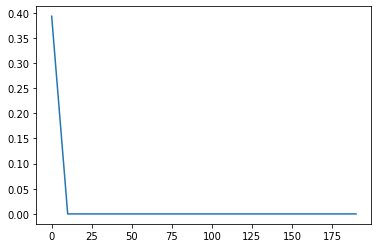

In [92]:
import matplotlib.pyplot as plt
plt.plot(epochs,losses)
plt.show()